In [74]:
#Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import warnings
from sklearn.linear_model import LinearRegression,ridge_regression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold

#Extra settings
pd.set_option('display.max_columns',None) # Will not truncate the display of columns 
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',None) 
# np.set_printoptions(linewidth=10) 

In [75]:
#Loading train and test data
try:
    train_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Dataset/train.csv')
    test_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Dataset/test.csv')
    print("Train df shape: " ,train_df.shape)
    print("Test df shape: ", test_df.shape)

except FileNotFoundError:
    print("File not found")

Train df shape:  (1460, 81)
Test df shape:  (1459, 80)


In [76]:
#train
numeric_df=train_df.select_dtypes(include='number')
numeric_df_cols=[col for col in numeric_df.columns]

numeric_df_cols.remove('MSSubClass')
numeric_df_cols.remove('MoSold')

numeric_df_updated=numeric_df[numeric_df_cols]
numeric_df_saleprice=numeric_df_updated['SalePrice']
numeric_df_updated_train=numeric_df_updated.drop('SalePrice',axis=1)

#test

numeric_df_test=test_df.select_dtypes(include='number')
numeric_df_test_cols=[col for col in numeric_df_test.columns]
numeric_df_test_cols.remove('MSSubClass')
numeric_df_test_cols.remove('MoSold')

numeric_df_updated_test=test_df[numeric_df_test_cols]
numeric_df_updated_test=numeric_df_updated_test


In [77]:
#Removing Null
numeric_df_updated_train=numeric_df_updated_train.fillna(0)
numeric_df_updated_test=numeric_df_updated_test.fillna(0)

numeric_df_updated_train_Id=numeric_df_updated_train['Id']
numeric_df_updated_test_Id=numeric_df_updated_test['Id']
numeric_df_updated_train=numeric_df_updated_train.drop('Id',axis=1)
numeric_df_updated_test=numeric_df_updated_test.drop('Id',axis=1)


In [78]:
# combined_df_model1_df = pd.concat([train_df_numeric, test_df_numeric], axis=0, ignore_index=True)
numeric_df_updated_test.head(5)
print(numeric_df_updated_train.shape,numeric_df_updated_test.shape)

(1460, 34) (1459, 34)


In [79]:
#Create pipeline
rfe = RFE(estimator=LinearRegression(),n_features_to_select=1)
model=LinearRegression()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(pipeline, numeric_df_updated_train, numeric_df_saleprice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Model 1:','MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Model 1: MAE: -33765.293 (2517.736)


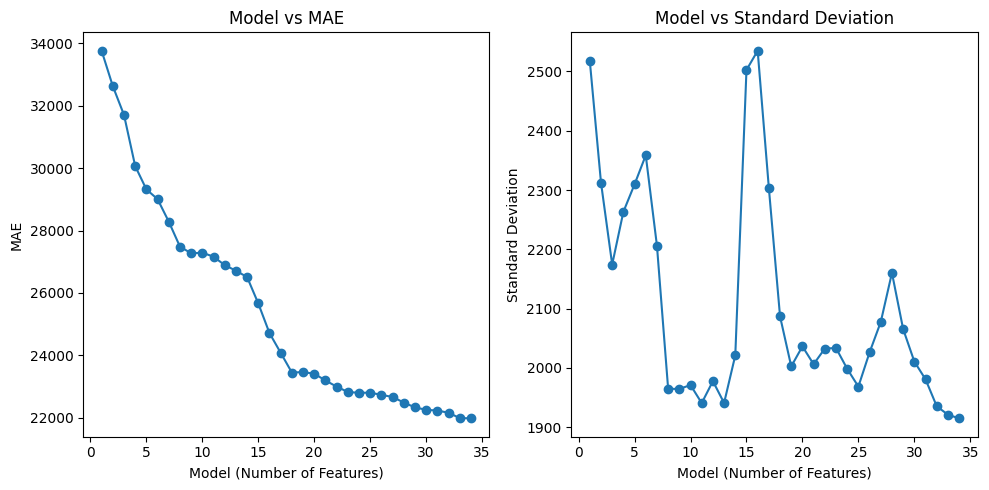

Around 15-20 features seems to be a good starting point. MAE has plateaued, and the standard deviation, while
not the absolute lowest, is relatively stable in this range.
Features beyond 20 offer minimal MAE improvement and come with more erratic standard deviation.
This suggests overfitting - the model might be picking up noise in the data rather than true patterns.



In [87]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, cross_val_score
from numpy import mean, std

Final_col = [col for col in numeric_df_updated_train.columns]
selected_features_dict = {}  # Store selected features for each model
Final_eval=[]

for i in range(1, len(Final_col) + 1):
    # Create pipeline
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
    model = LinearRegression()
    pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

    # Evaluate model
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    n_scores = cross_val_score(pipeline, numeric_df_updated_train, numeric_df_saleprice, 
                                scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    
    # Fit the pipeline on all training data to get selected features
    pipeline.fit(numeric_df_updated_train, numeric_df_saleprice)
    selected_feature_indices = pipeline.named_steps['s'].support_
    selected_features = list(numeric_df_updated_train.columns[selected_feature_indices])
    selected_features_dict[i] = selected_features  # Store in the dictionary

    # Report performance
   # print(f'Model {i}: MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    
    Final_eval.append({
        'Model': i,
        'MAE': -mean(n_scores),  # Negate to get positive MAE
        'Std Dev': std(n_scores),
        'Features': ', '.join(selected_features_dict[i])
    })

Final_eval_df=pd.DataFrame(Final_eval)

plt.figure(figsize=(10, 5))  # Adjust figure size as needed

# Plot Model vs MAE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(Final_eval_df['Model'], Final_eval_df['MAE'], marker='o', linestyle='-')
plt.xlabel('Model (Number of Features)')
plt.ylabel('MAE')
plt.title('Model vs MAE')

# Plot Model vs Std Dev
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(Final_eval_df['Model'], Final_eval_df['Std Dev'], marker='o', linestyle='-')
plt.xlabel('Model (Number of Features)')
plt.ylabel('Standard Deviation')
plt.title('Model vs Standard Deviation')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


# # Print selected features for each model
# for i in range(1, len(Final_col) + 1):
#     print(f"Model {i} - Selected Features: {selected_features_dict[i]}")

print('Around 15-20 features seems to be a good starting point. MAE has plateaued, and the standard deviation, while\n\
not the absolute lowest, is relatively stable in this range.\n\
Features beyond 20 offer minimal MAE improvement and come with more erratic standard deviation.\n\
This suggests overfitting - the model might be picking up noise in the data rather than true patterns.\n')



In [90]:
#Features to use
Final_eval_df[Final_eval_df['Model']==20]

,Model,MAE,Std Dev,Features
19,20,23408.318669,2036.276027,"LotFrontage, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, 1stFlrSF, 2ndFlrSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, ScreenPorch, PoolArea, YrSold"


In [99]:
#Benchmark model
model1=LinearRegression()
model1.fit(numeric_df_updated_train, numeric_df_saleprice)
y_pred_model1=model1.predict(numeric_df_updated_test)
y_pred_model1_df=pd.DataFrame(y_pred_model1)
y_pred_model1_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model3.csv')

In [112]:
#Using 20 features 
Final_eval_df_20=Final_eval_df[Final_eval_df['Model']==20]
cols_from_RFE=list(Final_eval_df_20['Features'])
cols_from_RFE = cols_from_RFE[0].split(', ')
numeric_df_updated_train_20_feat=numeric_df_updated_train[cols_from_RFE]
numeric_df_updated_test_20_feat=numeric_df_updated_test[cols_from_RFE]

#model 2
model2=LinearRegression()
model2.fit(numeric_df_updated_train_20_feat, numeric_df_saleprice)
y_pred_model2=model2.predict(numeric_df_updated_test_20_feat)
y_pred_model2_df=pd.DataFrame(y_pred_model2)
y_pred_model2_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model4.csv')